<center><img src="car.jpg" width=500></center>


Insurance companies invest a lot of time and money into optimizing their pricing and accurately estimating the likelihood that customers will make a claim. In many countries it is a legal requirement to have car insurance in order to drive a vehicle on public roads, so the market is very large!

(`Source: https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf`) 

**Scenario:**, ***On the Road*** car insurance has requested your services in building a model to predict whether a customer will make a claim on their insurance during the policy period. As they have very little expertise and infrastructure for deploying and monitoring machine learning models, they've asked you to identify the single feature that results in the best performing model, as measured by accuracy, so they can start with a simple model in production.

### Objective

Identify the single feature of the data that is the best predictor of whether a customer will put in a claim (the "outcome" column), excluding the "id" column.

They have supplied you with their customer data as a csv file called `car_insurance.csv`, along with a table detailing the column names and descriptions below.



## The dataset

| Column | Description |
|--------|-------------|
| `id` | Unique client identifier |
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |
| `education` | Client's level of education: <br> <ul><li>`0`: No education</li><li>`1`: High school</li><li>`2`: University</li></ul> |
| `income` | Client's income level: <br> <ul><li>`0`: Poverty</li><li>`1`: Working class</li><li>`2`: Middle class</li><li>`3`: Upper class</li></ul> |
| `credit_score` | Client's credit score (between zero and one) |
| `vehicle_ownership` | Client's vehicle ownership status: <br><ul><li>`0`: Does not own their vehilce (paying off finance)</li><li>`1`: Owns their vehicle</li></ul> |
| `vehcile_year` | Year of vehicle registration: <br><ul><li>`0`: Before 2015</li><li>`1`: 2015 or later</li></ul> |
| `married` | Client's marital status: <br><ul><li>`0`: Not married</li><li>`1`: Married</li></ul> |
| `children` | Client's number of children |
| `postal_code` | Client's postal code | 
| `annual_mileage` | Number of miles driven by the client each year |
| `vehicle_type` | Type of car: <br> <ul><li>`0`: Sedan</li><li>`1`: Sports car</li></ul> |
| `speeding_violations` | Total number of speeding violations received by the client | 
| `duis` | Number of times the client has been caught driving under the influence of alcohol |
| `past_accidents` | Total number of previous accidents the client has been involved in |
| `outcome` | Whether the client made a claim on their car insurance (response variable): <br><ul><li>`0`: No claim</li><li>`1`: Made a claim</li></ul> |

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

In [2]:
df_car_ins = pd.read_csv("car_insurance.csv")
df_car_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

In [3]:
df_car_ins.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## `age`

Age is encoded as a categorical variable with 4 levels 0-4. These levels are ordinal in that the higher the level, the higher the age range being represented in that bucket. Because of this oridinality, we can treat these as continuous variables for analysis purposes.

| Column | Description |
|--------|-------------|
| `age` | Client's age: <br> <ul><li>`0`: 16-25</li><li>`1`: 26-39</li><li>`2`: 40-64</li><li>`3`: 65+</li></ul> |



In [4]:
# start by getting just the data we need for this predictor
df_age = df_car_ins.loc[:, ['age', 'outcome']]
df_age.head()  # age is encoded, no need to convert

,age,outcome
0,3,0.0
1,0,1.0
2,0,0.0
3,0,0.0
4,1,1.0


In [5]:
# contingency table
contingency_age = pd.crosstab(df_age['age'], df_age['outcome'], margins=True)
print(contingency_age, "\n")

contingency_age_norm = pd.crosstab(df_age['age'], df_age['outcome'], margins=True, normalize='index')
print(contingency_age_norm)

outcome   0.0   1.0    All
age                       
0         568  1448   2016
1        2031  1032   3063
2        2474   457   2931
3        1794   196   1990
All      6867  3133  10000 

outcome       0.0       1.0
age                        
0        0.281746  0.718254
1        0.663075  0.336925
2        0.844081  0.155919
3        0.901508  0.098492
All      0.686700  0.313300


+ As we'd expect, the older the drive, the less likely they are to file a claim.
+ Model will predict **Made a claim** for the first age bucket (16-25), but predict **No claim** for the other 3 age buckets.

In [6]:
threshold = 0.5  # make threshold explicit

mdl_age = logit("outcome ~ age", data=df_age).fit()

exploratory_data = pd.DataFrame({"age": np.arange(0, 4, 1)})
prediction_data = exploratory_data.assign(
    prob_filed = mdl_age.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['prob_filed'] > threshold).astype(float)

Optimization terminated successfully.
         Current function value: 0.511794
         Iterations 6


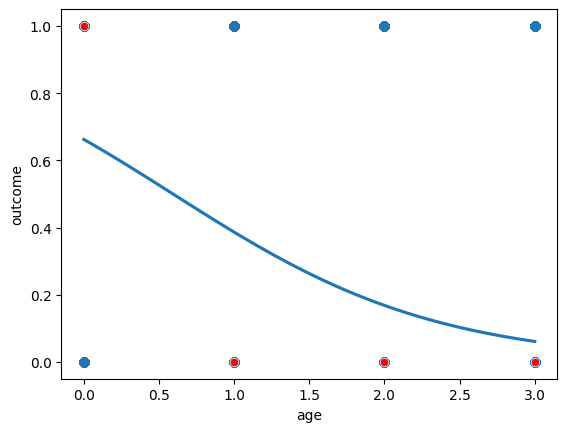

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_log_reg(x_act, x_pred, y_act, y_pred, df_act, df_pred):
    """ plots the results of a binary logistic regression model

    Args:
        x_act (str): name of the 
        x_pred (str):
        y_act (str):
        y_pred (str):
        df_act (Dataframe):
        df_pred (Dataframe):
    """
    sns.regplot(x=x_act, 
                y=y_act, 
                data=df_act, 
                ci=None, 
                logistic=True)

    sns.scatterplot(x=x_pred, 
                    y=y_pred, 
                    data=df_pred, 
                    color="red")

    plt.show()

# print(df_age.columns)
# print(prediction_data.columns)

plot_log_reg("age", "age", "outcome", "pred_outcome", df_age, prediction_data)

This plot looks like what we should expect:
+ *as age increase, probability of making a claim drops*
+ Model predicts a claim filing only in `age` = 0 bucket (red dot in the top part of the plot)
+ Model predicts `No claim` if `age` > 0

In [8]:
# compute confusion matrix
df_age['prob_file'] = mdl_age.predict(df_age['age'])
df_age['pred_file'] = (df_age['prob_file'] > threshold).astype(float)
conf_matrix = mdl_age.pred_table()
print(conf_matrix)
# print(type(conf_matrix))

[[6299.  568.]
 [1685. 1448.]]


In [9]:
# extract TN, TP, FN and FP from confusion matix
def get_accuracy(confusion_matrix):
    """ Calculated the accuracy from the confusion matrix

    Args:
        confusion_matrix (ndarray) - confusion matrix with rows as the actual values and columns as the predict values

    Returns:
        float: accuracy based on the confusion matrix
    """
    TN = confusion_matrix[0, 0]
    TP = confusion_matrix[1, 1]
    FN = confusion_matrix[1, 0]
    FP = confusion_matrix[0, 1]

    # print(f"TN = {TN}, TP = {TP}, FN = {FN}, "FP = {FP}")
    
    return ((TN + TP) / (TN + TP + FN + FP))

accuracy_age = get_accuracy(conf_matrix)
print(f"\nAccuracy using age only: {accuracy_age}")


Accuracy using age only: 0.7747


## `gender`

Gender is a binary categorical variable.

| Column | Description |
|--------|-------------|
| `gender` | Client's gender: <br> <ul><li>`0`: Female</li><li>`1`: Male</li></ul> |

In [10]:
# start by getting just the data we need for this predictor
df_gender = df_car_ins.loc[:, ['gender', 'outcome']]
# contingency table
contingency_table = pd.crosstab(df_gender['gender'], df_gender['outcome'], margins=True)
print(contingency_table, "\n")
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome   0.0   1.0    All
gender                    
0        3689  1321   5010
1        3178  1812   4990
All      6867  3133  10000 

outcome   0.0   1.0    All  prob_file
gender                               
0        3689  1321   5010   0.263673
1        3178  1812   4990   0.363126
All      6867  3133  10000   0.313300


Data suggest that women will file claims 26.4% of the time. Men will file 36.3% of the time. This is not a big difference, so we shouldn't expect this predictor to do very well.

In [11]:
mdl_gender = logit("outcome ~ gender", data=df_gender).fit()

exploratory_data = pd.DataFrame({"gender": np.array([0, 1])})
prediction_data = exploratory_data.assign(
    prob_filed = mdl_gender.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['prob_filed'] > threshold).astype(float)

Optimization terminated successfully.
         Current function value: 0.615951
         Iterations 5


[[6867.    0.]
 [3133.    0.]]

Accuracy using gender only: 0.6867



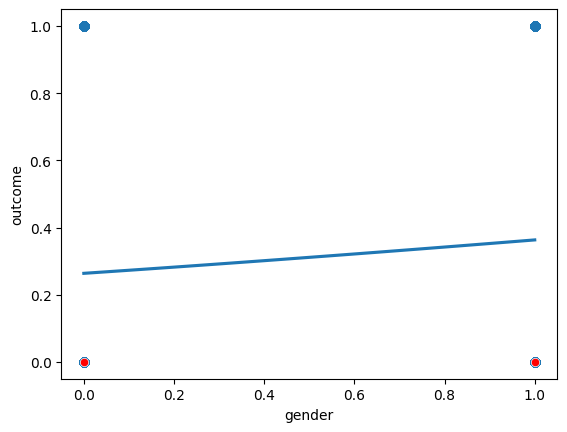

In [12]:
# compute confusion matrix
df_gender['prob_file'] = mdl_gender.predict(df_gender['gender'])
# df_age['prob_file'].unique()  # array([0.26367265, 0.36312625]) which are the values we computed above
df_gender['pred_file'] = (df_gender['prob_file'] > threshold).astype(float)
conf_matrix = mdl_gender.pred_table()
print(conf_matrix)  # neither gender shows > 50% probability of filing, so model will always predict "No claim"

accuracy_gender = get_accuracy(conf_matrix)
print(f"\nAccuracy using gender only: {accuracy_gender}\n")

plot_log_reg("gender", "gender", "outcome", "pred_outcome", df_gender, prediction_data)

+ The plot above looks a little funny because we're looking at a binary predictor, but is what we expect: *slightly high probability of filing if you are male*.
+ Since the probability of filing a claim is less than the threshold (50%) regardless of the `gender`, a model using this as the only predictor will always predict **No claim**.

### but what if we lowered the threshold and predicted all men would file a claim?

In this case, the `gender` column would be the same as the prediction.

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix_all_men = confusion_matrix(df_gender['outcome'], df_gender['gender'])
print(confusion_matrix_all_men, "\n")

accuracy_all_men = get_accuracy(confusion_matrix_all_men)
print(f"\nAccuracy predicting all men file: {accuracy_all_men}\n")  # as suspected, this model would does even worse...

[[3689 3178]
 [1321 1812]] 


Accuracy predicting all men file: 0.5501



## `driving_experience`

Like `age`, `driving_experience` is encoded as a categorical variable with 4 levels 0-4. These levels are also ordinal in that the higher the level, the more driving exprience being represented in that bucket. Because of this oridinality, we can treat these as continuous variables for analysis purposes.

| Column | Description |
|--------|-------------|
| `driving_experience` | Years the client has been driving: <br> <ul><li>`0`: 0-9</li><li>`1`: 10-19</li><li>`2`: 20-29</li><li>`3`: 30+</li></ul> |

This predictor may be **correlated** with the `age` predictor. Let's do a quick visual check.

In [14]:
df_age_drex = df_car_ins.loc[:, ['age', 'driving_experience', 'outcome']]
df_age_drex['driving_experience'].unique()

array(['0-9y', '10-19y', '20-29y', '30y+'], dtype=object)

In [15]:
df_age_drex = df_car_ins.loc[:, ['age', 'driving_experience', 'outcome']]
# need to convert driving_experience into an int representing the oridinality of the data
df_age_drex['encoded_drex'] = df_age_drex['driving_experience']
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('0-9y', '0')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('10-19y', '1')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('20-29y', '2')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].str.replace('30y+', '3')
df_age_drex['encoded_drex'] = df_age_drex['encoded_drex'].astype(float)

df_age_drex['encoded_drex'].unique()

array([0., 1., 2., 3.])

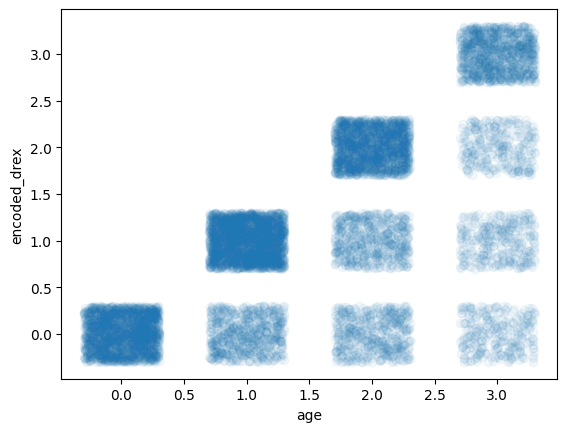

In [16]:
sns.regplot(data=df_age_drex, x='age', y='encoded_drex', fit_reg = False, x_jitter = 0.3, y_jitter = 0.3, scatter_kws = {'alpha' : 1/20})
plt.show()  # looks strong on the diagonal, but there are some older drivers with less experience

In [17]:
# contingency table
contingency_table = pd.crosstab(df_age_drex['driving_experience'], df_age_drex['outcome'], margins=True)
# print(contingency_table)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
# print(contingency_table.index)
# print(print(contingency_table.columns))
print(contingency_table)

outcome              0.0   1.0    All  prob_file
driving_experience                              
0-9y                1313  2217   3530   0.628045
10-19y              2512   787   3299   0.238557
20-29y              2010   109   2119   0.051439
30y+                1032    20   1052   0.019011
All                 6867  3133  10000   0.313300


Like the `age` predictor, we have one bucket (`0-9y`) that will be predicted as `Made a claim` and the others will not.

Optimization terminated successfully.
         Current function value: 0.467390
         Iterations 7


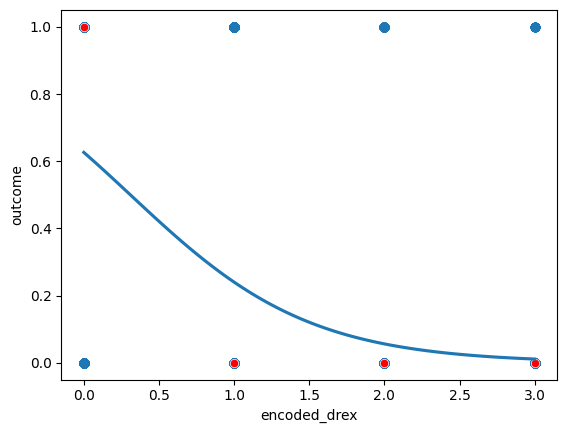

In [18]:
mdl_drex = logit("outcome ~ encoded_drex", data=df_age_drex).fit()

exploratory_data = pd.DataFrame({"encoded_drex": np.arange(0, 4, 1)})  # 4 buckets 0, 1, 2, 3
prediction_data = exploratory_data.assign(
    pred_outcome = mdl_drex.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['pred_outcome'] > threshold).astype(float)
plot_log_reg("encoded_drex", "encoded_drex", "outcome", "pred_outcome", df_age_drex, prediction_data)  # similar shape to age plot

In [19]:
# compute confusion matrix
df_age_drex['prob_file'] = mdl_drex.predict(df_age_drex['encoded_drex'])
df_age_drex['pred_file'] = (df_age_drex['prob_file'] > threshold).astype(float)
conf_matrix = mdl_drex.pred_table()
print(conf_matrix)

[[5554. 1313.]
 [ 916. 2217.]]


In [20]:
accuracy_drex = get_accuracy(conf_matrix)
print(f"\nAccuracy using driving experience only: {accuracy_drex}")  # a little better than age (0.7747 vs 0.7771), **BEST SO FAR**


Accuracy using driving experience only: 0.7771


## `education`

This is a 3-level categorical variable:
+ 0: No education
+ 1: High school
+ 2: University

The `no education` class showed the highest rate of filing and over twice the rate of the `University` class as shown in the contigency table below. Similar to what was found with `gender`, all levels have a probability of making a claim that is under 50%, so this variable alone has limited predictive power.

In [21]:
df_ed = df_car_ins.loc[:, ['education', 'outcome']]
# df_ed['education'].unique()  # array(['high school', 'none', 'university'], dtype=object), need encoding

In [22]:
# encode education levels
df_ed['education'] = df_ed['education'].replace({'none': '0', 'high school': '1', 'university': '2'})
df_ed['education'] = df_ed['education'].astype(float)
df_ed.head()

,education,outcome
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,2.0,0.0
4,0.0,1.0


In [23]:
contingency_ed = pd.crosstab(df_ed['education'], df_ed['outcome'], margins=True)
contingency_ed['prob_file'] = contingency_ed[1.0] / contingency_ed["All"]
contingency_ed  # all three level below 50%, so model will always predict  `No claim` and results will be similar to gender (accuracy = 0.6867)

outcome,0.0,1.0,All,prob_file
education,,,,
0.0,1012,903,1915,0.47154
1.0,2813,1344,4157,0.32331
2.0,3042,886,3928,0.22556
All,6867,3133,10000,0.31330


## `income`

Similar to `age` and `drivign_experience`, this is a 4-level categorical variable

In [24]:
df_inc = df_car_ins.loc[:, ['income', 'outcome']]
print(df_inc['income'].unique(), "\n")  # ['upper class' 'poverty' 'working class' 'middle class'], need encoding
# pd.set_option('future.no_silent_downcasting', True)
df_inc['income'] = df_inc['income'].replace({'poverty': '0', 'working class': '1', 'middle class': '2', 'upper class': '3'})
df_inc['income'] = df_inc['income'].astype(float)

contingency_inc = pd.crosstab(df_inc['income'], df_inc['outcome'], margins=True)
contingency_inc['prob_file'] = contingency_inc[1.0] / contingency_inc["All"]
contingency_inc

['upper class' 'poverty' 'working class' 'middle class'] 



outcome,0.0,1.0,All,prob_file
income,,,,
0.0,628,1186,1814,0.653804
1.0,936,776,1712,0.453271
2.0,1546,592,2138,0.276894
3.0,3757,579,4336,0.133533
All,6867,3133,10000,0.313300


Optimization terminated successfully.
         Current function value: 0.531580
         Iterations 5


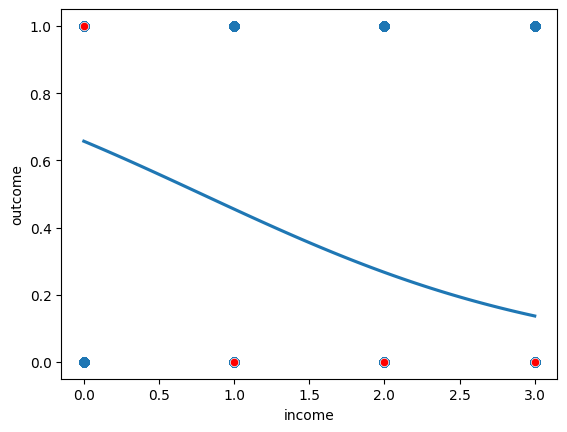

In [25]:
mdl_inc = logit("outcome ~ income", data=df_inc).fit()

exploratory_data = pd.DataFrame({"income": np.arange(0, 4, 1)})  # 4 buckets 0, 1, 2, 3
prediction_data = exploratory_data.assign(
    pred_outcome = mdl_inc.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['pred_outcome'] > threshold).astype(float)
plot_log_reg("income", "income", "outcome", "pred_outcome", df_inc, prediction_data)  # similar shape to age plot

In [26]:
# compute confusion matrix
df_inc['prob_file'] = mdl_inc.predict(df_inc['income'])
df_inc['pred_file'] = (df_inc['prob_file'] > threshold).astype(float)
conf_matrix = mdl_inc.pred_table()
print(conf_matrix, "\n")

# compute accuracy
accuracy_inc = get_accuracy(conf_matrix)
print(f"\nAccuracy using income only: {accuracy_inc}")  # simliar to, but a little worse than age and driving experience: 0.7425 vs (0.7747, 0.7771)

[[6239.  628.]
 [1947. 1186.]] 


Accuracy using income only: 0.7425


## `credit_score`

This is continuous variable...

In [27]:
df_credit = df_car_ins.loc[:, ['credit_score', 'outcome']]
df_credit['credit_score'].describe()  # looks like just under 10% of these values are missing

count    9018.000000
mean        0.515813
std         0.137688
min         0.053358
25%         0.417191
50%         0.525033
75%         0.618312
max         0.960819
Name: credit_score, dtype: float64

Optimization terminated successfully.
         Current function value: 0.567469
         Iterations 6


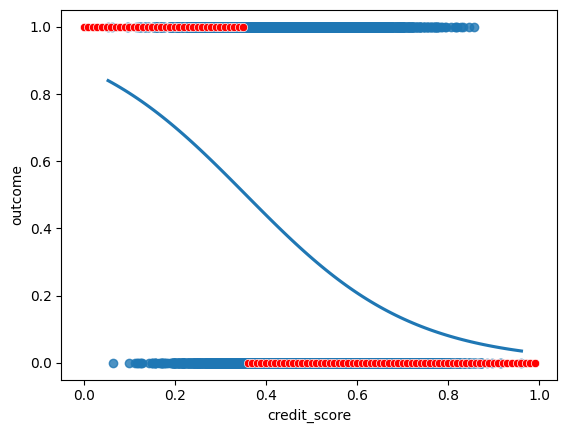

In [28]:
mdl_credit = logit("outcome ~ credit_score", data=df_credit).fit()

exploratory_data = pd.DataFrame({"credit_score": np.arange(0, 1, 0.01)})  # 
prediction_data = exploratory_data.assign(
    pred_outcome = mdl_credit.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['pred_outcome'] > threshold).astype(float)
plot_log_reg("credit_score", "credit_score", "outcome", "pred_outcome", df_credit, prediction_data)  # similar shape to age plot

In [29]:
# compute confusion matrix
df_credit['prob_file'] = mdl_credit.predict(df_credit['credit_score'])
df_credit['pred_file'] = (df_credit['prob_file'] > threshold).astype(float)
conf_matrix = mdl_credit.pred_table()
print(conf_matrix, "\n")

# compute accuracy
accuracy_credit = get_accuracy(conf_matrix)
print(f"\nAccuracy using credit score only: {accuracy_credit}")  # simliar to, but a little worse than income, age and driving experience (0.7425, 0.7747, 0.7771)

[[5650.  539.]
 [2106.  723.]] 


Accuracy using credit score only: 0.7066977156797516


## `vehicle_ownership`

Binary categorical:
+ 0: Does not own their vehilce (paying off finance)
+ 1: Owns their vehicle

In [30]:
df_owns = df_car_ins.loc[:, ['vehicle_ownership', 'outcome']]
# df_owns.head()  # looks like it's already encoded
contingency_table = pd.crosstab(df_owns['vehicle_ownership'], df_owns['outcome'], margins=True)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome             0.0   1.0    All  prob_file
vehicle_ownership                              
0.0                1273  1757   3030   0.579868
1.0                5594  1376   6970   0.197418
All                6867  3133  10000   0.313300


In [31]:
# predict all non owners file - no need for logistic regression model
df_owns["pred_outcome"] = (df_owns["vehicle_ownership"] - 1).abs()

In [32]:
confusion_matrix_not_owns = confusion_matrix(df_owns['outcome'], df_owns['pred_outcome'])
print(confusion_matrix_not_owns, "\n")

accuracy_not_owns = get_accuracy(confusion_matrix_not_owns)
print(f"\nAccuracy predicting all non-owners file: {accuracy_not_owns}\n")  # similar, but driving experience still best (0.7771)

[[5594 1273]
 [1376 1757]] 


Accuracy predicting all non-owners file: 0.7351



## `vehicle_year`

Like other binary predictor variables we've seen so far, one level sticks out. In this case it's `Before 2015`.

In [33]:
df_vyear = df_car_ins.loc[:, ['vehicle_year', 'outcome']]
df_vyear['vehicle_year'].unique()  # needs encoding
df_vyear["encoded_veh_year"] = df_vyear['vehicle_year'].replace({'before 2015': '0', 'after 2015': '1'})
df_vyear["encoded_veh_year"] = df_vyear["encoded_veh_year"].astype(float)
contingency_table = pd.crosstab(df_vyear['encoded_veh_year'], df_vyear['outcome'], margins=True)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome            0.0   1.0    All  prob_file
encoded_veh_year                              
0.0               4157  2810   6967   0.403330
1.0               2710   323   3033   0.106495
All               6867  3133  10000   0.313300


In [34]:
# predict all people with vehicles registered before 2015 file - no need for logistic regression model
df_vyear["pred_outcome"] = (df_vyear["encoded_veh_year"] - 1).abs()
confusion_matrix_vyear = confusion_matrix(df_vyear['outcome'], df_vyear['pred_outcome'])
print(confusion_matrix_vyear, "\n")

accuracy_vyear = get_accuracy(confusion_matrix_vyear)
print(f"\nAccuracy predicting all people with vehicles registered before 2015 file: {accuracy_vyear}\n")  # better to predict that none will file, driving experience still best (0.7771)

[[2710 4157]
 [ 323 2810]] 


Accuracy predicting all people with vehicles registered before 2015 file: 0.552



## `married`

Binary categorical:
+ 0: Not married
+ 1: Married

In [35]:
df_married = df_car_ins.loc[:, ['married', 'outcome']]
# df_married['married'].unique()  # alread encoded
contingency_table = pd.crosstab(df_married['married'], df_married['outcome'], margins=True)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome   0.0   1.0    All  prob_file
married                              
0.0      2838  2180   5018   0.434436
1.0      4029   953   4982   0.191289
All      6867  3133  10000   0.313300


In [36]:
# predict all unmarried file - no need for logistic regression model
df_married["pred_outcome"] = (df_married["married"] - 1).abs()  # again, need to flip the bits of this binary column
confusion_matrix_married = confusion_matrix(df_married['outcome'], df_married['pred_outcome'])
print(confusion_matrix_married, "\n")

accuracy_married = get_accuracy(confusion_matrix_married)
print(f"\nAccuracy predicting all un-married people file: {accuracy_married}\n")  # better to predict that none will file (0.6867), driving experience still best (0.7771)

[[4029 2838]
 [ 953 2180]] 


Accuracy predicting all un-married people file: 0.6209



## `children`

This is supposed to be the number of children, but the variable looks binary. Probable (assumed) meaning: **1 = client has children, 0 = client has not children**

In [37]:
df_kids = df_car_ins.loc[:, ['children', 'outcome']]
# df_kids['children'].unique()  # appears to binary, not really the number of kids
contingency_table = pd.crosstab(df_kids['children'], df_kids['outcome'], margins=True)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome    0.0   1.0    All  prob_file
children                              
0.0       1637  1475   3112   0.473972
1.0       5230  1658   6888   0.240708
All       6867  3133  10000   0.313300


In [38]:
# predict all childless file - no need for logistic regression model
df_kids["pred_outcome"] = (df_kids["children"] - 1).abs()  # again, need to flip the bits of this binary column
confusion_matrix_kids = confusion_matrix(df_kids['outcome'], df_kids['pred_outcome'])
print(confusion_matrix_kids, "\n")

accuracy_kids = get_accuracy(confusion_matrix_kids)
print(f"\nAccuracy predicting all childless people file: {accuracy_kids}\n")  # better to predict that none will file (0.6867), driving experience still best (0.7771)

[[5230 1637]
 [1658 1475]] 


Accuracy predicting all childless people file: 0.6705



## `postal_code`

This is a 4-level categorical variable encoded as an integer. This is **NOT** ordinal, so we need to change the type.

Looks like every client in one of the levels (postal code 21217) filed a claim. However, this is small number relative to the total claims (120 vs 3133). The othe postal codes show a fairly even distribution, we don't need to build a model to know this isn't going to be a very good predictor.

In [39]:
df_car_ins["postal_code"].unique()

array([10238, 32765, 92101, 21217], dtype=int64)

In [40]:
df_zip = df_car_ins.loc[:, ['postal_code', 'outcome']]
df_zip['postal_code'] = df_zip['postal_code'].astype('category')

contingency_table = pd.crosstab(df_zip['postal_code'], df_zip['outcome'], margins=True)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome       0.0   1.0    All  prob_file
postal_code                              
10238        5054  1886   6940   0.271758
21217           0   120    120   1.000000
32765        1529   927   2456   0.377443
92101         284   200    484   0.413223
All          6867  3133  10000   0.313300


## `annual_mileage`

Another continuous variable...

In [41]:
df_car_ins['annual_mileage'].describe()  # about 10% of values are missing here as well

count     9043.000000
mean     11697.003207
std       2818.434528
min       2000.000000
25%      10000.000000
50%      12000.000000
75%      14000.000000
max      22000.000000
Name: annual_mileage, dtype: float64

Optimization terminated successfully.
         Current function value: 0.601906
         Iterations 5


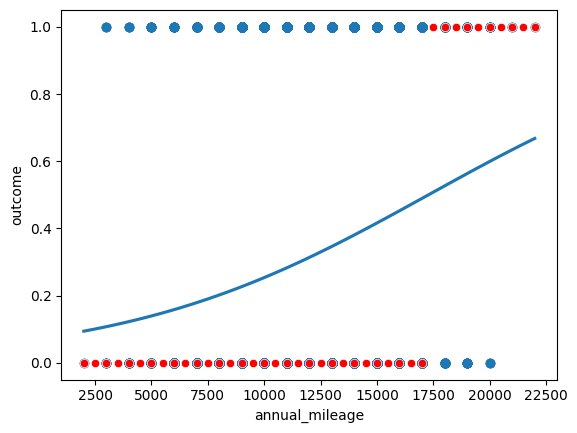

In [42]:
mdl_miles = logit("outcome ~ annual_mileage", data=df_car_ins).fit()

exploratory_data = pd.DataFrame({"annual_mileage": np.arange(2000, 22500, 500)})  # 
prediction_data = exploratory_data.assign(
    pred_outcome = mdl_miles.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['pred_outcome'] > threshold).astype(float)
plot_log_reg("annual_mileage", "annual_mileage", "outcome", "pred_outcome", df_car_ins, prediction_data)

In [43]:
# compute confusion matrix
miles_prob_file = mdl_miles.predict(df_car_ins['annual_mileage'])
miles_pred_file = (miles_prob_file > threshold).astype(float)
conf_matrix = mdl_miles.pred_table()
print(conf_matrix, "\n")

# compute accuracy
accuracy_miles = get_accuracy(conf_matrix)
print(f"\nAccuracy using annual vehicle mileage only: {accuracy_miles}")  # not so hot, driving experience still best (0.7771)

[[6167.   66.]
 [2707.  103.]] 


Accuracy using annual vehicle mileage only: 0.6933539754506248


## `vehicle_type`

Binary categorical:
+ 0: Sedan
+ 1: Sports car

Most vehicles are sedan in this data set, so most of the claims will naturally come from this class. Not very informative as a predictor by itself.

In [44]:
df_vtype = df_car_ins.loc[:, ['vehicle_type', 'outcome']]
# df_kids['children'].unique()  # appears to binary, not really the number of kids
contingency_table = pd.crosstab(df_vtype['vehicle_type'], df_vtype['outcome'], margins=True)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome        0.0   1.0    All  prob_file
vehicle_type                              
sedan         6545  2978   9523   0.312717
sports car     322   155    477   0.324948
All           6867  3133  10000   0.313300


## `speeding_violations`

As shown in the plot, this variable alone has no predictive power.

Optimization terminated successfully.
         Current function value: 0.558922
         Iterations 7


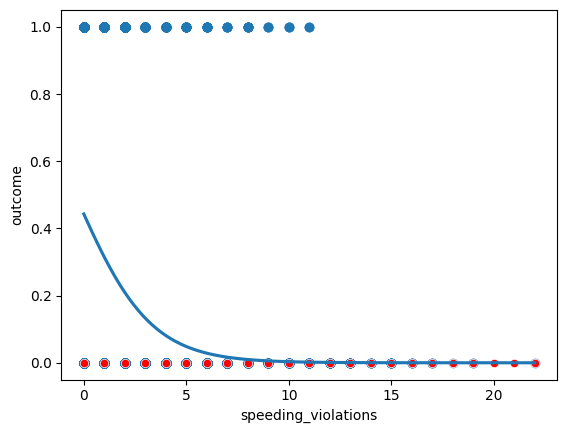

In [45]:
df_speed = df_car_ins.loc[:, ['speeding_violations', 'outcome']]
# np.sort(df_speed['speeding_violations'].unique())  # 21 values, treat as continuous
mdl_speed = logit("outcome ~ speeding_violations", data=df_speed).fit()

exploratory_data = pd.DataFrame({"speeding_violations": np.arange(0, 23, 1)})  # 
prediction_data = exploratory_data.assign(
    pred_outcome = mdl_speed.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['pred_outcome'] > threshold).astype(float)
plot_log_reg("speeding_violations", "speeding_violations", "outcome", "pred_outcome", df_speed, prediction_data)

## duis

Number of times the client has been caught driving under the influence of alcohol. Large majority of sample have 0 duis and is where most of the filings come from, so this won't be very useful predictor by itself either.

In [46]:
df_dui = df_car_ins.loc[:, ['duis', 'outcome']]
np.sort(df_dui['duis'].unique())  # [0, 1, 2, 3, 4, 5, 6]

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [47]:
contingency_table = pd.crosstab(df_dui['duis'], df_dui['outcome'], margins=True)
contingency_table['prob_file'] = contingency_table[1.0] / contingency_table["All"]
print(contingency_table)

outcome   0.0   1.0    All  prob_file
duis                                 
0        5204  2914   8118   0.358955
1        1282   188   1470   0.127891
2         309    22    331   0.066465
3          62     6     68   0.088235
4           7     3     10   0.300000
5           2     0      2   0.000000
6           1     0      1   0.000000
All      6867  3133  10000   0.313300


## past_accidents

This is not a good predictor for similar reasons described as to why `speeding_violations` is not a good predictor.

In [48]:
df_accs = df_car_ins.loc[:, ['past_accidents', 'outcome']]
np.sort(df_accs['past_accidents'].unique())  # [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15],
      dtype=int64)

Optimization terminated successfully.
         Current function value: 0.549220
         Iterations 7


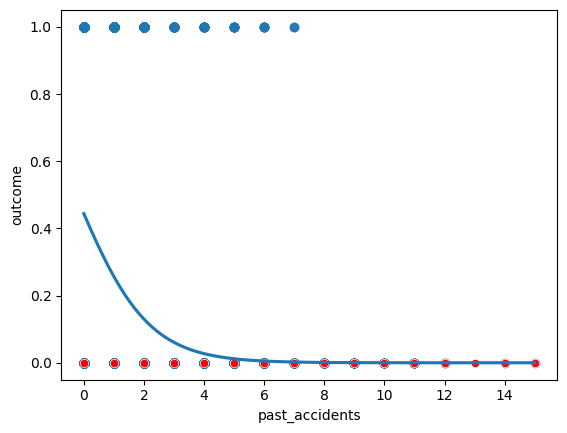

In [49]:
mdl_accs = logit("outcome ~ past_accidents", data=df_accs).fit()

exploratory_data = pd.DataFrame({"past_accidents": np.arange(0, 16, 1)})  # 
prediction_data = exploratory_data.assign(
    pred_outcome = mdl_accs.predict(exploratory_data)
)

prediction_data['pred_outcome'] = (prediction_data['pred_outcome'] > threshold).astype(float)
plot_log_reg("past_accidents", "past_accidents", "outcome", "pred_outcome", df_accs, prediction_data)

## Best Feature

`driving_experience` is the best single feature for predicting claim filing.

In [50]:
best_feature_df = pd.DataFrame({"best_feature": ["driving_experience"], "best_accuracy": [accuracy_drex]})
print(best_feature_df)

         best_feature  best_accuracy
0  driving_experience         0.7771
